# Chapter 09 시계열을 위한 머신러닝

## 9.1 시계열 분류

### 9.1.1 특징의 선택과 생성

### 필요한 데이터셋 다운로드
    * EEG 데이터셋
      각 시계열의 길이가 같음
      1. 눈을 뜨거나 감은(두 개의 별도 범주) 건강한 사람에 대한 EEG 기록
      2. 발작이 발생하지 않은 간질 환자의 발작과는 관련 없는 두뇌의 두 부위에 대한 EEG 기록 (두개의 별도 범주)
      3. 발작 중 뇌파 내 EEG 기록 (단일 범주)


In [1]:
!pip install cesium

     |████████████████████████████████| 220 kB 8.2 MB/s 
     |████████████████████████████████| 554 kB 52.9 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43819 sha256=04f060d83d18aded77de04be16f8951efcc3c094d5a3bcb3a62d328f57d368e5
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [2]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

데이터 일부 샘플을 통해 분류를 위한 아이디어 파악

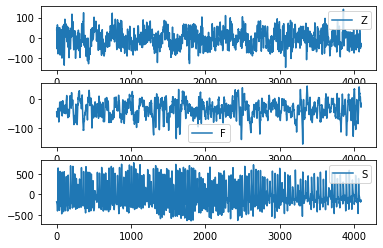

In [3]:
import matplotlib.pyplot as plt
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

cesium을 통한 특징의 생성 밥법

In [4]:
from cesium.featurize import featurize_time_series as ft

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   "skew",
                   "max_slope"]

fset_cesium = ft(times = eeg["times"],
                 values = eeg["measurements"],
                 errors = None,
                 features_to_use = features_to_use,
                 scheduler = None)

In [5]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


오류 검사 by percent_beyond_1_std

In [6]:
import numpy as np

np.std(eeg["measurements"][0])

40.41100040099819

In [7]:
np.mean(eeg["measurements"][0])

-4.1320478398828415

In [8]:
sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = -4.13 - 40.4
ul = -4.13 + 40.4
quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] >ul]

len(quals) / sz # 위에서의 값과 일치

0.3273126678057115

### 9.1.2 결정 트리 기법

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg["classes"], random_state=21)

랜덤포레스트

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth    =  3,
                                random_state = 21)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [11]:
rf_clf.score(X_test, y_test)

0.616

그레디언트 부스팅 트리

In [12]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators  = 10,
                            max_depth     =  3,
                            random_state  = 21)

xgb_clf.fit(X_train, y_train)

XGBClassifier(n_estimators=10, objective='multi:softprob', random_state=21)

In [13]:
xgb_clf.score(X_test, y_test)

0.648

각 모델의 학습시간 추정</br>
(정식적인 방식은 아님)

In [14]:
import time

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
(end - start) * 100

1.8355846405029297

In [15]:
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
(end - start) * 100

1.7090082168579102

두 앙상블에 대해 동일한 트리 개수를 부여하고, 트리들의 깊이를 제한하여 복잡도를 낮춘 경우<br/>
그레디언트 부스팅 모델의 정확도가 더 높게 나옴

In [16]:
# 트리 수(10), but 복잡성은 낮춘 경우를 테스트
# max_depth = 2

# XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=10,
                            max_depth=2,
                            random_state=21)

xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.616

In [17]:
# 랜덤포레스트
rf_clf = RandomForestClassifier(n_estimators=10,
                                max_depth=2,
                                random_state=21)

rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.544

트리의 복잡성을 낮추더라도 동일한 결과

In [18]:
# max_depth = 1

# XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=10,
                            max_depth=1,
                            random_state=21)

xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.632

In [19]:
# 랜덤포레스트
rf_clf = RandomForestClassifier(n_estimators=10,
                                max_depth=1,
                                random_state=21)

rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.376

## 9.2 클러스터링

In [20]:
!pip install dtaidistance

     |████████████████████████████████| 535 kB 6.4 MB/s 


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix

from dtaidistance import dtw

from collections import Counter

from scipy.stats import pearsonr

데이터 불러오기

In [22]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                    header = None)

In [23]:
words.rename(columns = {0:'word'}, inplace = True)

In [24]:
words.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,-0.500440,-0.460820,-0.42469,-0.39240,-0.36389,-0.33906,-0.31795,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.31086,-0.321350,-0.333260,-0.346500,-0.361030,-0.37659,-0.39297,-0.40995,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.51587,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.73517,-0.75286,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.83768,-0.84538,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,0.035301,0.080601,0.12121,0.16167,0.20223,0.23973,0.27386,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.48213,0.472450,0.459290,0.443090,0.424040,0.40053,0.37585,0.35189,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.12352,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.70017,-0.74901,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.87721,-0.87661,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,-0.971990,-0.964030,-0.96355,-0.96236,-0.95077,-0.91733,-0.87105,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.85764,0.775790,0.634510,0.480380,0.351620,0.24100,0.11593,-0.02214,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.42135,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.48431,-0.52010,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.72646,-0.74568,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,-0.312890,0.339420,0.98909,1.33000,1.34950,1.22290,1.04450,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.52032,-0.427310,-0.291990,-0.066752,0.241280,0.61050,0.96181,1.21160,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.49790,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.53268,-0.53688,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.65382,-0.66957,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,-0.390180,-0.339310,-0.29231,-0.24833,-0.20635,-0.16585,-0.12719,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.05167,0.032078,0.008739,-0.017323,-0.046021,-0.07580,-0.10581,-0.13622,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.32809,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.57506,-0.60889,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.84805,-0.87959,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


In [25]:
words.word[1]

12

범주별 데이터 1D 히스토그램으로 표현

Text(0.5, 0.8, 'Histogram of projection Word 13')

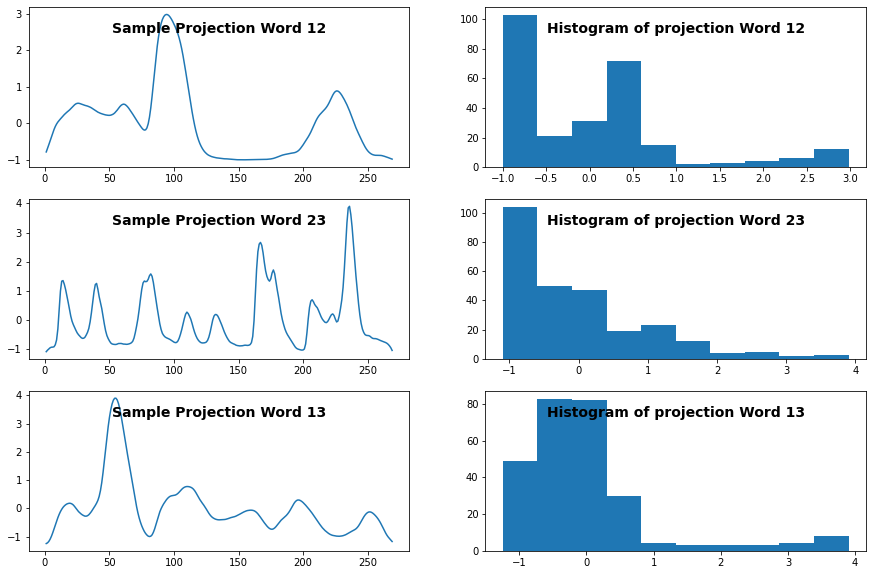

In [26]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight='bold', y=0.8, fontsize=14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of projection Word " + str(words.word[1]), fontweight='bold', y=0.8, fontsize=14)

plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight='bold', y=0.8, fontsize=14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of projection Word " + str(words.word[3]), fontweight='bold', y=0.8, fontsize=14)

plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[5]), fontweight='bold', y=0.8, fontsize=14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of projection Word " + str(words.word[5]), fontweight='bold', y=0.8, fontsize=14)

예시의 단어가 이상치가 아님을 확인하기 위해 단어의 차이를 확인<br/>
두 단어에 대한 2D 히스토그램 구성

In [27]:
# word = 12

x = np.array([])
y = np.array([])

w = 12
selected_words = words[words.word == w]
selected_words.shape

(9, 271)

Text(0, 0.5, 'Value')

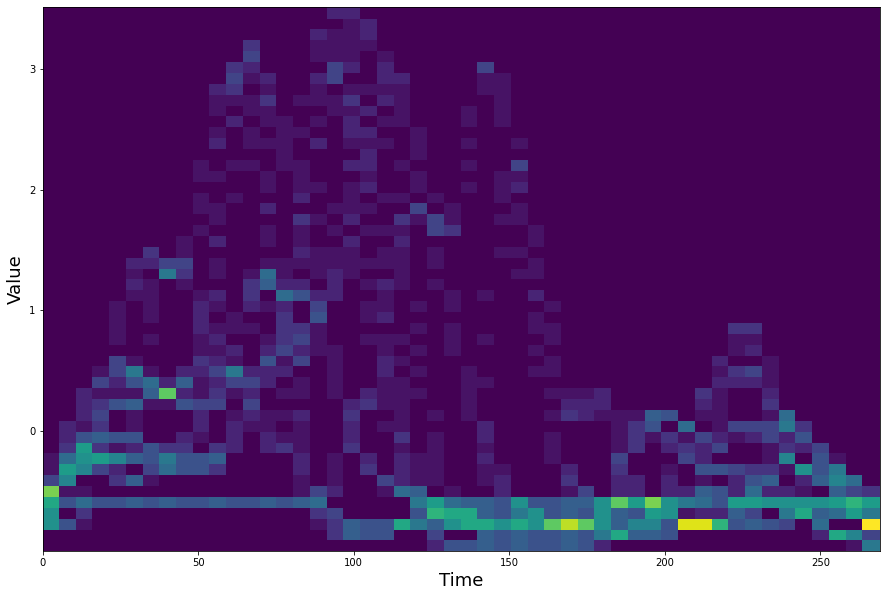

In [28]:
for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])

fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

In [29]:
# word = 23

x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

(4, 271)

Text(0, 0.5, 'Value')

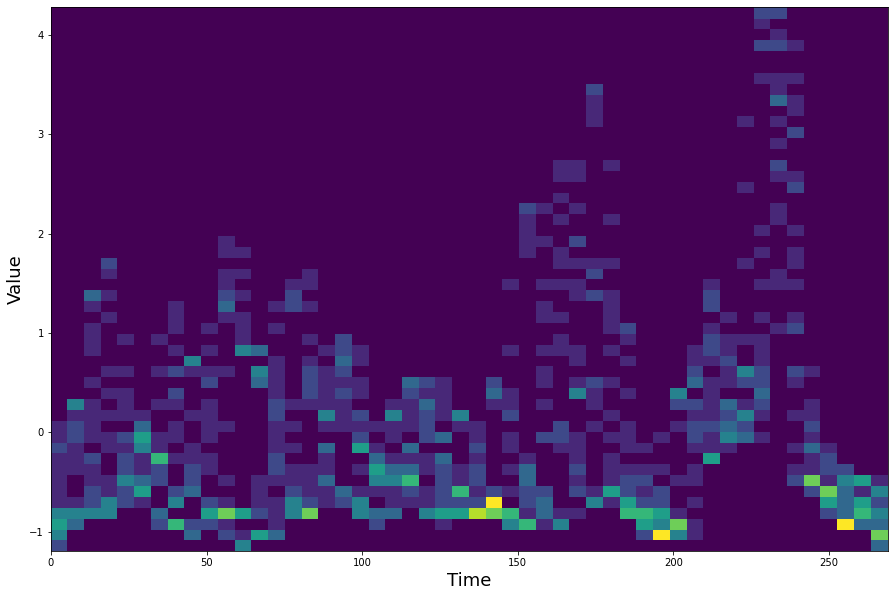

In [30]:
for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])

fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

시간 단계 270개를 가진 시계열의 특징을 생성

In [31]:
from cesium.featurize import featurize_time_series as ft

word_vals = words.iloc[:, 1:271]
times = []
word_values = []

for idx, row in word_vals.iterrows():
    word_values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'percent_close_to_median']
featurized_words = ft(times = times,
                      values = word_values,
                      errors = None,
                      features_to_use = features_to_use,
                      scheduler = None)

히스토그램을 생성하고 이를 또 다른 시계열로 취급하여 특징 생성

In [32]:
times = []
hist_values = []

for idx, row in word_vals.iterrows():
    hist_values.append(np.histogram(row.values,
                                    bins=10,
                                    range=(-2.5, 5.0))[0] + .0001)
                                    ## 0들은 하위 작업에서 문제를 초래함
    times.append(np.array([i for i in range(9)]))

features_to_use = ["amplitude",
                   "percent_close_to_median",
                   "skew"
                   ]

featurized_hists = ft(times = times,
                      values = hist_values,
                      errors = None,
                      features_to_use = features_to_use,
                      scheduler = None)

다른 방식으로 얻은 특징 결합

In [33]:
features = pd.concat([featurized_words.reset_index(drop=True),
                      featurized_hists],
                     axis=1)

### 9.2.2 시간을 인식하는 거리 측정법

DTW (동적 시간 왜곡)

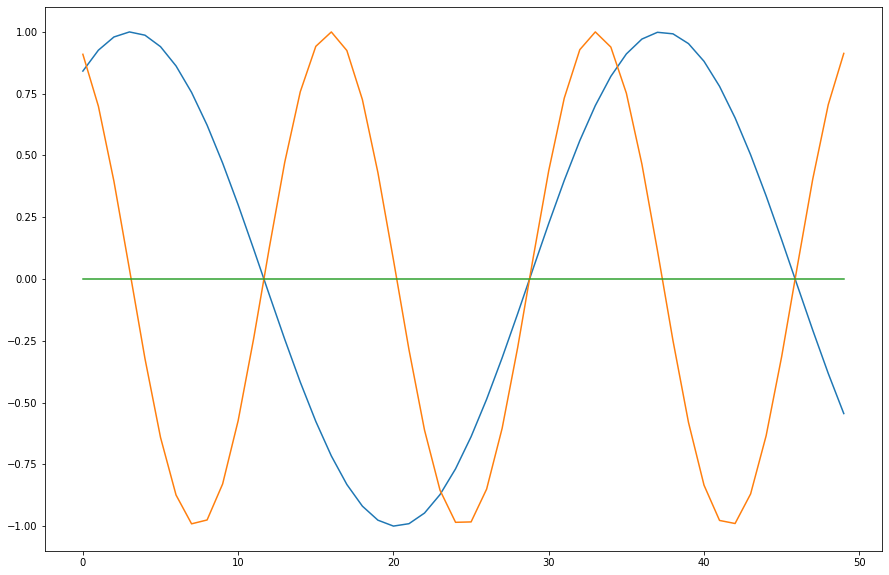

In [34]:
ts1 = np.sin(np.linspace(1, 10))
ts2 = np.sin(2 * np.linspace(1, 10))
ts3 = np.zeros((50,))
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)

In [35]:
# def distDTW(ts1, ts2):
#     # 설정과정
#     DTW = {}
#     for i in range(len(ts1)):
#         DTW[(i, -1)] = np.inf
#     for i in range(len(ts2)):
#         DTW[(-1, i)] = np.inf
#     DTW[(-1, -1)] = 0

#     # 한 번에 한 단계씩
#     # 최적값 계산
#     for i in range(len(ts1)):
#         for j in range(len(ts2)):
#             dist = (ts1[i] - ts2[j]) ** 2
#             DTW[(i, j)] = dist + min(DTW[(i-1, j)],
#                                      DTW[(i, j-1)],
#                                      DTW[(i-1, j-1)])
#             # 동적 프로그래밍의 한 예

#     # 완전한 경로를 찾으면 그 경로의 거리를 반환
#     return sqrt(DTW[len(ts1)-1, len(ts2)-1])

In [40]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

In [41]:
distDTW(ts1, ts2)

3.7609101849567645

In [45]:
X = words.iloc[:, 1:271].values

In [46]:
distDTW(X[0], X[1])

7.777960024318239

In [47]:
dtw.distance(X[0], X[1])

7.777960164340302

### 9.2.3 클러스터링 코드

정규화된 특징에 대한 계층적 클러스터링

In [48]:
# 단일 거리 지표 사용을 위한 정규화
feature_values = preprocessing.scale(features.values)

In [ ]:
p = pairwise_distances(X, metric = distDTW)

In [ ]:
# 50개 단어에 매칭되는 클러스터를 찾기
feature_clustering = AgglomerativeClustering(n_clusters = 50,
                                          linkage = 'ward')
feature_clustering.fit(feature_values)
words['feature_labels'] = feature_clustering.fit_predict(p)